Предсказание дохода.

Целью данной задачи является построение модели классификации пользователей: на вход модель будет принимать данные о человеке, а на выходе она должна предсказывать бинарный уровень дохода человека (больше или меньше 50 000$ за год)

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
from comet_ml import Experiment

In [80]:
#experiment = Experiment(project_name='Predict Income',api_key='ROXvPHdVV7aywYaR2JjvrBHzp',log_code=True)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/flint/predict-income/316081e0407246699d7cfd73145c1381



Загрузка данных

In [37]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

In [38]:
display(train_data.head())
display(test_data.head())

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States,0
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States,0


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,27,Private,Some-college,Divorced,Adm-clerical,Not-in-family,White,Female,0.0,0.0,38,United-States,0
1,45,State-gov,HS-grad,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40,United-States,0
2,29,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0.0,NaN,55,United-States,1
3,30,Private,Bachelors,Never-married,Machine-op-inspct,Not-in-family,White,Female,0.0,0.0,40,United-States,0
4,29,Self-emp-not-inc,Some-college,Divorced,Craft-repair,Not-in-family,White,Male,2202.0,0.0,50,United-States,0


Проверим размерности наших данных

In [39]:
print(train_data.shape)
print(test_data.shape)

(24420, 13)
(8141, 13)


NameError: name 'experiment' is not defined

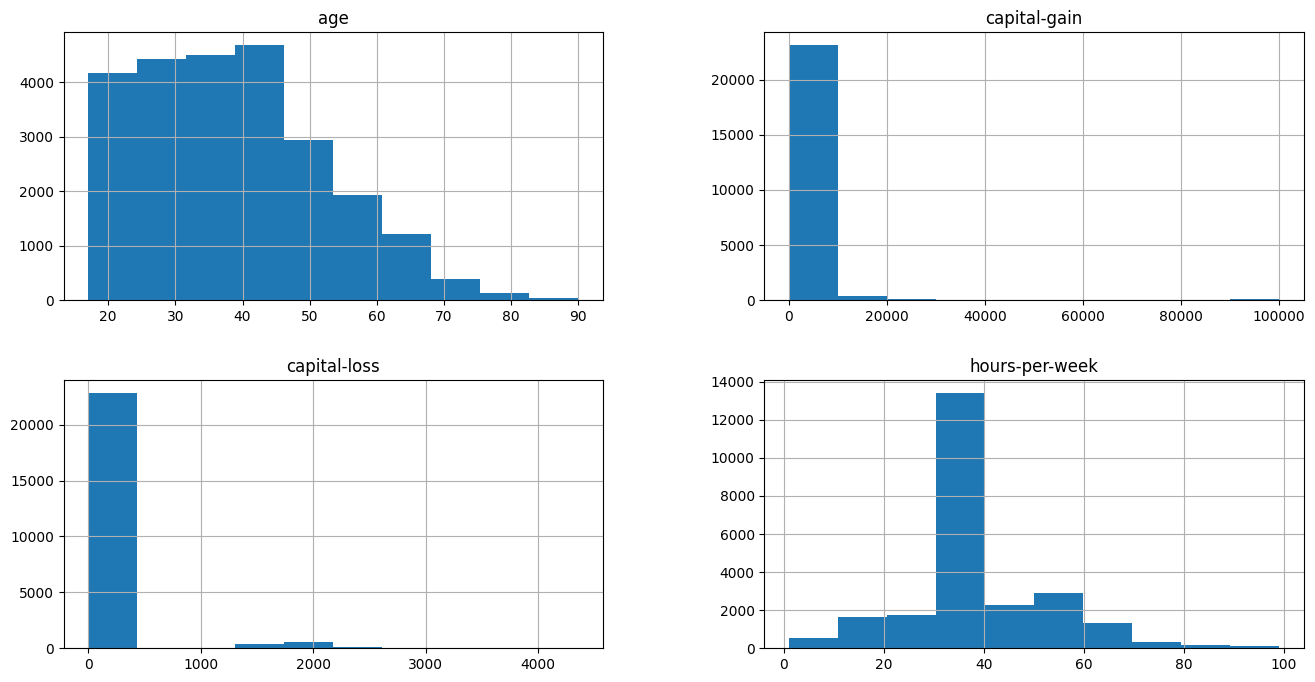

In [40]:
train_data.drop(['income'],axis=1).hist(figsize=(16,8));
experiment.log_figure('X_train_numeric_distr',plt)

In [82]:
experiment.log_figure('X_train_numeric_distr',plt)

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

Поиск пропусков

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
 12  income          24420 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 2.4+ MB


In [42]:
train_data.isnull().sum()

age                  0
workclass         1197
education          977
marital-status       0
occupation           0
relationship         0
race                 0
sex                  0
capital-gain       715
capital-loss       484
hours-per-week       0
native-country       0
income               0
dtype: int64

In [43]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,8141.0,38.532244,13.647073,17.0,27.0,37.0,48.0,90.0
capital-gain,7879.0,1177.948471,8059.229616,0.0,0.0,0.0,0.0,99999.0
capital-loss,7974.0,82.083647,394.114726,0.0,0.0,0.0,0.0,4356.0
hours-per-week,8141.0,40.590099,12.489254,1.0,40.0,40.0,45.0,99.0
income,8141.0,0.236703,0.425085,0.0,0.0,0.0,0.0,1.0


In [44]:
target_name='income'

In [45]:
X_train = train_data.drop([target_name],axis=1)
y_train = train_data[target_name]

X_test = test_data.drop([target_name],axis=1)
y_test = test_data[target_name]

In [46]:
y_train.value_counts(normalize=True)

0    0.757821
1    0.242179
Name: income, dtype: float64

In [47]:
X_train['capital-loss']=X_train['capital-loss'].fillna(0)
X_train['capital-gain']=X_train['capital-gain'].fillna(0)

In [48]:
X_test['capital-loss']=X_test['capital-loss'].fillna(0)
X_test['capital-gain']=X_test['capital-gain'].fillna(0)

In [49]:
X_train['workclass']=X_train['workclass'].fillna(X_train['workclass'].value_counts().index[0])
X_test['workclass']=X_test['workclass'].fillna(X_train['workclass'].value_counts().index[0])

In [50]:
X_train['education']=X_train['education'].fillna(X_train['education'].value_counts().index[0])
X_test['education']=X_test['education'].fillna(X_train['education'].value_counts().index[0])

In [51]:
X_train.isna().sum()

age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

In [52]:
# Формула, которая показывает список столбцов и наличие в них уникальных значений, для нашего понимания, сколько значений оставлять и какие столбцы числовые, а какие категориальные. 
unique_list = []
# пробегаемся по именам столбцов в таблице
for col in X_train.columns:
    # создаём кортеж (имя столбца, число уникальных значений)
    item = (col, X_train[col].nunique(),X_train[col].dtypes)     # добавляем кортеж в список
    unique_list.append(item) 
# создаём вспомогательную таблицу и сортируем её
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type']
).sort_values(by='Num_Unique',  ignore_index=True)
# выводим её на экран
display(unique_counts)

,Column_Name,Num_Unique,Type
0,sex,2,object
1,race,5,object
2,relationship,6,object
3,marital-status,7,object
4,workclass,9,object
5,occupation,15,object
6,education,16,object
7,native-country,42,object
8,age,73,int64
9,capital-loss,87,float64


In [53]:
categorial_features=['sex','race','relationship','marital-status','workclass','occupation','education','native-country']
numerical_feature=['age','capital-loss','hours-per-week','capital-gain']

In [54]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [55]:
X_train_labelEn=X_train.copy()
X_test_labelEn=X_test.copy()

In [56]:
X_train_labelEn[categorial_features]

,sex,race,relationship,marital-status,workclass,occupation,education,native-country
0,Male,White,Husband,Married-civ-spouse,Private,Craft-repair,HS-grad,United-States
1,Male,White,Husband,Married-civ-spouse,Private,Machine-op-inspct,HS-grad,United-States
2,Male,Black,Husband,Married-civ-spouse,Private,Other-service,11th,United-States
3,Male,White,Unmarried,Separated,Private,Adm-clerical,Bachelors,United-States
4,Female,White,Not-in-family,Divorced,Private,Sales,Bachelors,United-States
...,...,...,...,...,...,...,...,...
24415,Male,White,Husband,Married-civ-spouse,Private,Craft-repair,Bachelors,United-States
24416,Female,White,Unmarried,Divorced,Private,Other-service,12th,United-States
24417,Female,White,Own-child,Never-married,Private,Adm-clerical,11th,United-States
24418,Male,White,Husband,Married-civ-spouse,Self-emp-not-inc,Farming-fishing,HS-grad,United-States


In [57]:
LblEn=LabelEncoder()

In [58]:
for feature in categorial_features:
    X_train_labelEn[feature]=LblEn.fit_transform(X_train_labelEn[feature])
    X_test_labelEn[feature]=LblEn.fit_transform(X_test_labelEn[feature])

In [59]:
OneHotEn=OneHotEncoder()


In [60]:
X_trainONE=OneHotEn.fit_transform(X_train[categorial_features]).toarray()
cols=OneHotEn.get_feature_names_out()
X_trainONE=pd.DataFrame(X_trainONE,columns=cols)

In [61]:
X_train_ONE=pd.concat([X_train,X_trainONE],axis=1)
X_train_ONE.drop(columns=categorial_features,axis=1,inplace=True)


In [62]:
X_testONE=OneHotEn.transform(X_test[categorial_features]).toarray()
cols_1=OneHotEn.get_feature_names_out()
X_testONE=pd.DataFrame(X_testONE,columns=cols_1)

In [63]:
X_test_ONE=pd.concat([X_test,X_testONE],axis=1)
X_test_ONE.drop(columns=categorial_features,axis=1,inplace=True)

In [64]:
X_test_ONE

,age,capital-gain,capital-loss,hours-per-week,sex_Female,sex_Male,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,27,0.0,0.0,38,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,45,0.0,0.0,40,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29,0.0,0.0,55,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,30,0.0,0.0,40,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,29,2202.0,0.0,50,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,35,0.0,0.0,40,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8137,60,0.0,0.0,40,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8138,25,0.0,0.0,40,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8139,50,0.0,0.0,40,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Обучение модели.

In [65]:
from sklearn.linear_model import LogisticRegression

In [66]:
linear_model_le=LogisticRegression()
linear_model_oh=LogisticRegression()

In [67]:
linear_model_le.fit(X_train_labelEn,y_train)
linear_model_oh.fit(X_train_ONE,y_train)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

LogisticRegression()

In [68]:
X_test_labelEn

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,27,3,15,0,1,1,4,0,0.0,0.0,38,37
1,45,6,11,2,4,5,4,0,0.0,0.0,40,37
2,29,3,9,2,4,0,2,1,0.0,0.0,55,37
3,30,3,9,4,7,1,4,0,0.0,0.0,40,37
4,29,5,15,0,3,1,4,1,2202.0,0.0,50,37
...,...,...,...,...,...,...,...,...,...,...,...,...
8136,35,3,11,5,8,1,2,1,0.0,0.0,40,37
8137,60,3,4,2,12,0,4,1,0.0,0.0,40,0
8138,25,0,11,4,0,4,2,0,0.0,0.0,40,37
8139,50,3,9,2,12,0,4,1,0.0,0.0,40,37


In [69]:
X_test_ONE

,age,capital-gain,capital-loss,hours-per-week,sex_Female,sex_Male,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,27,0.0,0.0,38,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,45,0.0,0.0,40,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29,0.0,0.0,55,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,30,0.0,0.0,40,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,29,2202.0,0.0,50,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,35,0.0,0.0,40,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8137,60,0.0,0.0,40,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8138,25,0.0,0.0,40,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8139,50,0.0,0.0,40,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [70]:
predict_le=linear_model_le.predict(X_test_labelEn)
predict_le

array([0, 0, 0, ..., 0, 0, 1])

In [71]:
predict_oh=linear_model_oh.predict(X_test_ONE)
predict_oh

array([0, 1, 1, ..., 0, 1, 0])

In [72]:
from sklearn.metrics import accuracy_score
acc_oh=accuracy_score(y_test,predict_oh)
acc_le=accuracy_score(y_test,predict_le)
print(accuracy_score(y_test,predict_le))
print(accuracy_score(y_test,predict_oh))

0.8011300822994718
0.850141260287434


In [83]:
experiment.log_metric('Accuracy OneHot data',acc_oh)
experiment.log_metric('Accuracy La data',acc_le)

In [74]:
sum(predict_le)/len(predict_le)

0.10637513818941162

In [75]:
sum(predict_oh)/len(predict_oh)

0.1934651762682717

In [76]:
sum(y_test)/len(y_test)

0.23670310772632355

In [77]:
print(accuracy_score(y_test,np.zeros_like(y_test)))

0.7632968922736765


Таблица сопряженности

In [78]:
from sklearn.metrics import confusion_matrix

In [79]:
pd.DataFrame(confusion_matrix(y_test,predict_oh))

,0,1
0,5780,434
1,786,1141


In [84]:
experiment.log_confusion_matrix(y_test,predict_oh)

{'web': 'https://www.comet.com/api/asset/download?assetId=70c606fab33a49498e180117f7ec0b39&experimentKey=316081e0407246699d7cfd73145c1381',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=70c606fab33a49498e180117f7ec0b39&experimentKey=316081e0407246699d7cfd73145c1381',
 'assetId': '70c606fab33a49498e180117f7ec0b39'}

Прогноз вероятности принадлежности к классу.

In [85]:
predict_proba_oh=linear_model_oh.predict_proba(X_test_ONE)

In [87]:
predict_proba_oh_1=predict_proba_oh[:,1]

In [88]:
predict_proba_oh_1

array([0.04452961, 0.56820465, 0.73958073, ..., 0.0028821 , 0.62359374,
       0.32698103])

{'web': 'https://www.comet.com/api/image/download?imageId=c0cd9417460944629bd19c634094438f&experimentKey=316081e0407246699d7cfd73145c1381',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=c0cd9417460944629bd19c634094438f&experimentKey=316081e0407246699d7cfd73145c1381',
 'imageId': 'c0cd9417460944629bd19c634094438f'}

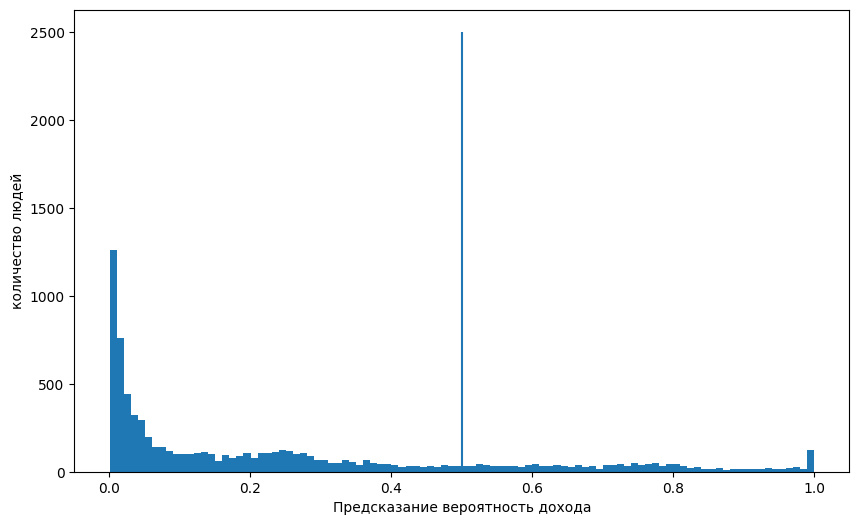

In [96]:
plt.figure(figsize=(10,6))
plt.hist(predict_proba_oh_1,bins=100);
plt.vlines(0.5,0,2500);
plt.xlabel('Предсказание вероятность дохода');
plt.ylabel('количество людей');
experiment.log_figure('predicted income',plt)

ROC кривая классификатора.

In [97]:
from sklearn.metrics import roc_curve

In [100]:
false_positive_rates,true_positive_rates,threshold=roc_curve(y_test,predict_proba_oh_1)

In [ ]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

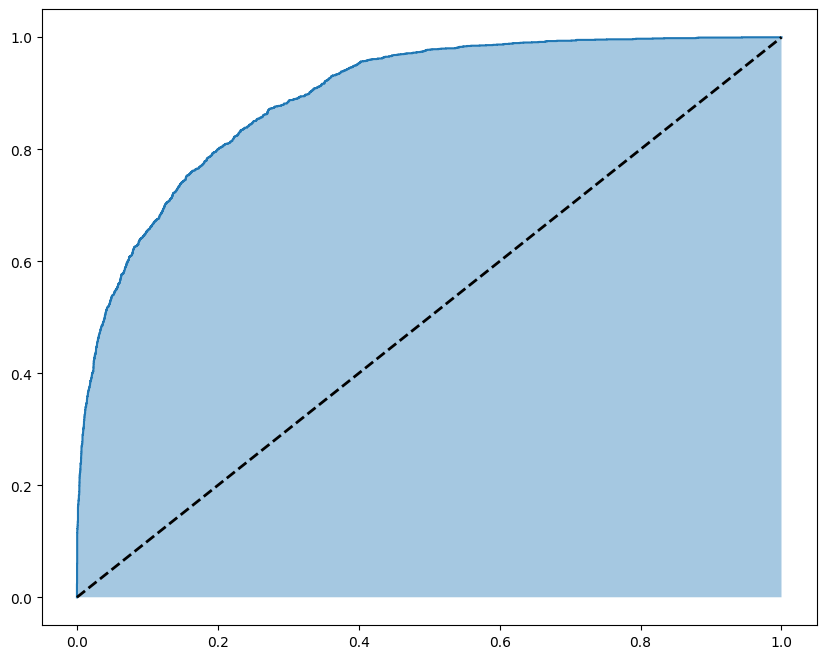

In [106]:
plt.figure(figsize=(10,8))
plt.plot(false_positive_rates,true_positive_rates,label='Сглаженные значения ROC')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', 
         label='Модель, выдающая случайное значение')
plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.show()